In [44]:
from keras.applications.resnet50 import ResNet50
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Activation
from keras.optimizers import SGD
from keras.regularizers import l2
import matplotlib.pyplot as plt

In [32]:
# Tamaño de lote para el optimizador
batch_size = 32
# Número de clases, ya se sabe por que se conoce el conjunto de datos
# pero si no, se puede hacer de forma programática
num_clases = 10
# Número de épocas, dejar como está porque es suficiente
epocas = 15

In [14]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

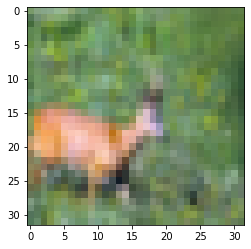

In [15]:
# Se puede visualizar una de estas imágenes para conocer el conjunto de datos
plt.imshow(x_train[82, :, :])

In [16]:
# Codificación One Hot para las etiquetas
y_train = to_categorical(y_train, num_clases)
y_test = to_categorical(y_test, num_clases)

In [17]:
# create the base pre-trained model
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=x_train.shape[1:])

/home/edwinb/anaconda3/envs/deep_workshop/lib/python3.7/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [45]:
# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, use_bias=False, kernel_regularizer=l2(1e-4))(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(num_clases, activation="softmax")(x)

In [46]:
# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [47]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

In [48]:
# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer=SGD(lr=0.01, momentum=0.9, decay=1e-5),
              loss="categorical_crossentropy",
             metrics=["accuracy"])

In [49]:
model.fit(x_train, y_train, epochs=epocas,
          batch_size=batch_size,
         validation_split=0.2)

Train on 40000 samples, validate on 10000 samples
Epoch 1/15
40000/40000 [==============================] - 229s 6ms/step - loss: 1.9284 - acc: 0.4081 - val_loss: 3.5716 - val_acc: 0.2503
Epoch 2/15
40000/40000 [==============================] - 222s 6ms/step - loss: 1.6961 - acc: 0.4652 - val_loss: 3.1198 - val_acc: 0.2696
Epoch 3/15
40000/40000 [==============================] - 222s 6ms/step - loss: 1.6156 - acc: 0.4923 - val_loss: 3.5548 - val_acc: 0.2381
Epoch 4/15
40000/40000 [==============================] - 222s 6ms/step - loss: 1.5423 - acc: 0.5162 - val_loss: 3.6649 - val_acc: 0.2420
Epoch 5/15
40000/40000 [==============================] - 221s 6ms/step - loss: 1.4904 - acc: 0.5317 - val_loss: 3.5724 - val_acc: 0.2408
Epoch 6/15
40000/40000 [==============================] - 222s 6ms/step - loss: 1.4468 - acc: 0.5444 - val_loss: 3.2894 - val_acc: 0.2629
Epoch 7/15
40000/40000 [==============================] - 222s 6ms/step - loss: 1.4097 - acc: 0.5622 - val_loss: 3.2542 - 